In [182]:
#Import dependencies
import numpy as np
import math
import random
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
from scipy.special import erfc

### Required Functions ###

In [183]:
#BPSK Modulation
def bpsk_mod(mu,L):
    from scipy.signal import upfirdn
    s_bb = upfirdn(h=[1]*L, x=mu, up = L) # NRZ encoder; upfirdn: Upsample, FIR filter, and downsample.
    t=np.arange(start = 0,stop = len(mu)*L) #discrete time base
    return (s_bb,t)

#BPSK demodulation        
def bpsk_demod(r_bb,L):
    x = np.real(r_bb) # I arm
    x = np.convolve(x,np.ones(L)) # integrate for Tb duration (L samples)
    x = x[L-1:-1:L] # I arm - sample at every L
    ak_hat = (x > 0).transpose() # threshold detector
    return ak_hat

#Noise (AP to BD)
def noise(s,SNRdB,L=1):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1: # if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s): # check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    #r = s + n # received signal
    return n

#Noise (BD to AP)
def awgn(s,SNRdB,L=1):
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1: # if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s): # check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal #AWGN channel
    return r

# In theoretical analyses and simulations, for AWGN, the channel gain ℎ is often considered as a complex Gaussian random variable 
# with unity magnitude (i.e.,|ℎ∣=1) and uniformly distributed phase between 0 and 2π. This assumption simplifies 
# the analysis and is a common model used in communication theory to characterize the effects of the channel.

### More Required Functions ###

In [184]:
#Pathloss Model - Log distance
def logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n):
    #Pt_dBm = Transmitted power in dBm
    #G_BD_dBi = Gain of the BD antenna in dBi
    #G_AP_dBi = Gain of the AP antenna in dBi
    #f = frequency of transmitted signal in Hertz
    #d0 = reference distance of receiver from the transmitter in meters
    #d = array of distances at which the loss needs to be calculated
    #L = Other System Losses, for no Loss case L=1
    #sigma = Standard deviation of log Normal distribution (in dB)
    #n = path loss exponent
    #Pr_dBm = Received power in dBm
    #PL = path loss due to log normal shadowing
    lamda_ = (3*10**8)/f #Wavelength in meters
    K = 20*math.log10((4*np.pi*d0)/lamda_) # Path Loss factor *******- 10*n*math.log10(d0) - 10*math.log10(L) #path-loss factor
    X = sigma*np.random.randn() #normal random variable
    PL_dB = Gt_dBi + Gr_dBi + K + 10*n*math.log10(d/d0) + X  #PL(d) including antennas gains
    
    #Pr_dBm = Pt_dBm + PL #Receieved power in dBm at d meters
    return PL_dB


#AP-BD Channel Gain
def APBD_ChannelGain(f):
    Pt_dBm = 30 #1W AP transmission power 1W = 30dBm
    Gt_dBi = 1 #Gain of the AP antenna in dBi 
    Gr_dBi = 1 #Gain of the BD antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 3 #distance between AP and BD #Throughput reduces significantly after 4 meters ()
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    G_dB = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    G = 10**(G_dB/10)
    return G

#J-AP Channel Gain
def JAP_ChannelGain(f):
    M = 5
    P_J = 10 #np.random.randint(low=1,high=M,dtype = int) #choose a number between 1-4
    Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 2 #distance between J and AP
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    G_dB = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    G = 10**(G_dB/10)
    return G

#J-BD Channel Gain
def JBD_ChannelGain(f):
    M = 5
    P_J = 10 #np.random.randint(low=1,high=M,dtype = int) #choose a number between 1-4
    Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 2 #distance between J and AP
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    G_dB = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    G = 10**(G_dB/10)
    return G

#Loopback Channel Gain (SIC)
def loopback_Channel():
    epsilon = 1e-10 #very small number
    Pt_dBm = 30 #should be same as AP transmission power
    #g_hat: feedback channel coefficient
    #g_bar = 7e-5 #g_bar: feedback channel coefficient estimation
    #g_tilde = 6e-5#g_tilde: estimation error
    #g_hat = g_bar + (sqrt(epsilon))*g_tilde 
    G = 1 #E[g_tilde**2]=1
    sigma = np.random.normal(loc=0.0, scale=1.0, size=None)
    phi = -20 #dBm 30dBm reduction = 60dB reduction, by current techniques, it has been reported that SI can be canceled up to −81 dB in analog domain
    combined_power_dB = (Pt_dBm+phi) + sigma**2
    combined_power = 10**(combined_power_dB/10)
    P = combined_power*epsilon*G
    return P

#print('X of APBD', APBD_ChannelGain(900e6)) #changing "logNormalShadowing" function to return X
#print('X of JBD', JBD_ChannelGain(900e6)) #changing "logNormalShadowing" function to return X
#print('X of JAP', JAP_ChannelGain(900e6)) #changing "logNormalShadowing" function to return X

#Comment: X follows same distribution for all channels (H,JAP,JBD), but X for each are different. Also, X changes in each time slot


### Number of steps/time slots ###

In [207]:
#Number of steps each episode will have. 1 step = 1 time slot
nSteps = 400 #number of time steps, in each time step, AP chooses a new channel ## 1 time step = 1 time slot

### System Parameters ###

In [208]:
#System parameters
N=10000 # Number of symbols to transmit
L=16 # oversampling factor,L=Tb/Ts(Tb=bit period,Ts=sampling period) Tb (bit period) = symbol duration = (1/900MHz) = 1.1ns
deltaf = 10e6 #frequency step
Fc = 900e6 #900MHz #base carrier frequency
Fs=L*Fc # sampling frequency
#Backscatter Reflection Coefficient - when the tag wants to transmits a 1, it reflects and absorbs when it wants to transmit a 0
mu = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
(s_bb,t)= bpsk_mod(mu,L) # BPSK modulation(waveform) - baseband

In [209]:
print(s_bb)

[0. 0. 0. ... 1. 1. 1.]


#### AP and Jammer Signal ####

In [210]:
### numpy.random.randn => Return a sample (or samples) from the “standard normal” distribution. 
#[Recall: The standard normal distribution is a specific type of normal distribution where the mean is equal to 0 
#and the standard deviation is equal to 1.]
### numpy.random.normal => Draw random samples from a normal (Gaussian) distribution. 

x = (np.random.randn(N*L) + 1j*np.random.randn(N*L))/np.sqrt(2) #Complex Gaussian with unity power of size N*L (N: # of symbols generated)
x_J = (np.random.randn(N*L) + 1j*np.random.randn(N*L))/np.sqrt(2) #Complex Gaussian with unity power of size N*L (N: # of symbols generated)

### Noise ###

In [211]:
#random.normal(loc=0.0, scale=1.0, size=None); loc => mean, scale => Standard deviation of the distribution (must be non-negative
def complex_noise(mean, variance, size):
    # Generate real and imaginary parts separately with normal distribution
    real_part = np.random.normal(mean, np.sqrt(variance), size)
    imag_part = np.random.normal(mean, np.sqrt(variance), size)
    
    # Combine real and imaginary parts into complex numbers
    complex_noise = real_part + 1j * imag_part
    
    return complex_noise
#complex_noise = complex_noise(0, 1, N*L) # Mean = 0, Variance = 1, Size = N*L

#### BD Battery State ####

In [212]:
E_B = np.zeros(nSteps)

for j in range(nSteps):
    P_T = 1 #AP transmission power: 1W
    M = 10 #Jammer power level upper limit
    P_J = np.random.randint(low=0,high=M,dtype = int) #choose a number between 1-4
    τ = 1#e-3 #duration of 1 time slot = 1ms
    ξ = 0.8 #energy harvesting efficiency
    #levels = 5 #5 discrete levels of BD energy
    #E_levels = np.arange(1, levels+1, 1, dtype=int)
    U_E = ξ*(P_J + P_T)*τ#*E_levels #Unit Energy #Signal energy doesn't depend upon frequency
    E_BC = 0.75*U_E # Let 1 Unit energy used, fixed, by tag circuit during BC operation
    E_EH = 0.25*U_E # Let 1 Unit energy used, fixed, by tag circuit during EH operation ### E_BC > E_EH
    E_h = U_E #Amount of energy harvested #Energy harvested is function of time and power
    E_B [j] = mu[j]*E_BC - (1 - mu[j])*E_EH + (1 - mu[j])*E_h + 1*U_E

In [ ]:
def Jammer(n):
    M = 5 #Jammer power level upper limit
    P_J = np.random.randint(low=0,high=M,dtype = int) #choose a power level between 0 to 4 W and
    #P_J = 10*math.log10(P_J_Watt) + 30  #convert P_J to dBm
    #seq = [0,1,2,3]
    #n = n+1
    #if n == len(seq):
    #    n = 0
    k_J = np.random.randint(low=0,high=4,dtype = int) #seq[n]
    #print(n)
    f_J = Fc + (k_J*deltaf) 
    return (P_J,f_J,n)

### Jammer Strategy ###

In [213]:
def Jammer(n):
    M = 5 #Jammer power level upper limit
    P_J = 10 # np.random.randint(low=0,high=M,dtype = int) #choose a power level between 0 to 4 W and
    #P_J = 10*math.log10(P_J_Watt) + 30  #convert P_J to dBm
    deltaf = 10e6 #frequency step
    Fc = 900e6 #900MHz #base carrier frequency
    seq = [0,1,2,3]
    n = n+1
    if n == len(seq):
        n = 0
    k_J = seq[n]
    #print(n)
    f_J = Fc #+ (k_J*deltaf)  #Jammer staying only on one channel
    return (P_J,f_J,n)

In [214]:
## Mean Jamming Power Received at AP ##
def Mean_Jam_Power(P_J,f_J):
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    lambda_ = (3*10**8)/(f_J)
    d = 2 #distance between J and AP
    n=2 # path loss exponent
    PR_J = P_J*((Gt_dBi*Gr_dBi*(lambda_**2))/((d**n)*(4*np.pi)**2)) # in Watt
    return PR_J 

### State Space, Action Space ###

In [215]:
# AP - learning agent:
#State: channel selected, {1, 2, ..., K}
#Action: channel jumped to, {1, 2, ..., K}
#Reward: instantaneous throughput, observed SNR, or packet delivery result {delivered: reward 1; otherwise: reward 0}. Note that a packet not delivered does not necessarily indicate a packet drop; it could be just due to the tag in harvesting mode.
#Then AP can adopt Q-learning

state_space = np.array([0,1,2,3])
action_space = np.array([0,1,2,3])

In [216]:
q_table = np.zeros((len(state_space), len(action_space)))
print(q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Trainning Phase

In [217]:
#training parameters
#In this case, number of steps per episode = number of time slots per episode
#No terminating condition - each episode run up to "nSteps" - time slots

num_episodes = 200 #total no. of episodes the agent will play during training
max_steps_per_episode = nSteps #one of the terminating condition, max no. steps in a single episode

learning_rate = 0.1 #high LR focus more on new, less on old; low LR learn nothing, use prior knowledge
discount_rate = 0.99 #high DR focus more on distant reward, low DR focus more on immediate reward

#epsilon-greedy
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

In [218]:
all_epochs = []
all_iterations = []
all_exploration_rate = []
rewards_all_steps = []
avg_reward_all_episodes = []
#rewards_current_step = 0
iterations = 0
epochs = 0
reward = np.zeros(max_steps_per_episode)
P_R_AP = np.zeros(max_steps_per_episode)
P_N = np.zeros(max_steps_per_episode)
SNR = np.zeros(max_steps_per_episode)

n= -1

# Q-learning algorithm
for episode in range(num_episodes):
    current_state = 0
    epochs += 1
    rewards_current_step = 0
    rewards_each_episode = []
    #avg_reward = 0
    for step in range(max_steps_per_episode):
        iterations += 1
        # Exploration-exploitation trade-off
        p0 = random.uniform(0, 1)
        if p0 > exploration_rate:
            action = np.argmax(q_table[current_state][:]) #gives the index of the column with highest Q-value corresponding to row = current_state
            #print('Exploited Action: ',action)
        else:
            action = random.choice(action_space)
            #print('Random Action: ',action)
        k = action #channel is decided based on e-greedy
        f_k = Fc + (k*deltaf)
        P_T = 1 #AP transmission power: 1W
        M = 5 #Jammer power level upper limit
        P_J = np.random.randint(low=0,high=M,dtype = int) #choose a power level between 0 to 4 W and
        #P_J = 10*math.log10(P_J_Watt) + 30  #convert P_J to dBm
        
        #Jammer Strategy: 
        (P_J,f_J,n) = Jammer(n)
        
        P_R = ((s_bb**2)*P_T*(APBD_ChannelGain(f_k))**2) 
        P_R_AP[step] = sum(P_R)/(N*L) #Average Received Power
        Noise_variance = (P_R_AP[step])/(10**(20/10)) #Desired SNR assumed to be 20dB
        unwanted_signal = 1*(f_k == f_J)*P_J*JAP_ChannelGain(f_J) + loopback_Channel() + Noise_variance*abs(complex_noise(0, 1, N*L))
        ### 1*(f_k == f_J)*... => 0 if f_K is not equal to f_J
        P_N[step] = sum(unwanted_signal)/(N*L)
        SNR[step] =  P_R_AP[step]/P_N[step]
        #print(SNR)
        reward[step] = math.log2(1+SNR[step]) #SNR in linear scale will give throughput in bps; Here, throughput (reward) is in bps/Hz
        #print(reward)
        #next state
        new_state = action
      
        # Update Q-table for Q(s,a)
        q_table[current_state, action] = q_table[current_state, action] * (1 - learning_rate) + \
        learning_rate * (reward[step] + discount_rate * np.max(q_table[new_state, :]))
        # Transition to the next state
        current_state = new_state
              
        # Add new reward   
        
        rewards_current_step = reward[step]
        rewards_each_episode.append(rewards_current_step)
        rewards_all_steps.append(rewards_current_step)
        all_iterations.append(iterations)
    avg_reward = sum(rewards_each_episode)/max_steps_per_episode
    avg_reward_all_episodes.append(avg_reward)
    # Exploration rate decay (at the end of one episode, we need to update the exploration rate)
    exploration_rate = min_exploration_rate + \
    (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    all_epochs.append(epochs)
    all_exploration_rate.append(exploration_rate)


In [219]:
# Print updated Q-table
print("\n\n********Q-table********\n")
print(q_table)



********Q-table********

[[109.23492779 111.72434506 109.17720404 110.13421463]
 [111.17311143 111.22166754 111.23704562 111.32184444]
 [110.41089656 111.46357588 109.80247975 110.37892868]
 [110.33360135 111.46597379 110.78199008 109.88588971]]


## Plots ##

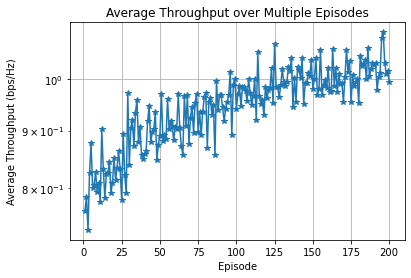

In [220]:
#Plotting average throughput over 100 episodes

fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(all_epochs,avg_reward_all_episodes,'-*')
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Throughput (bps/Hz)')
ax1.set_title('Average Throughput over Multiple Episodes')
plt.grid(True)

#plt.savefig('avg_throughput_all_episodes_200_episodes.png')

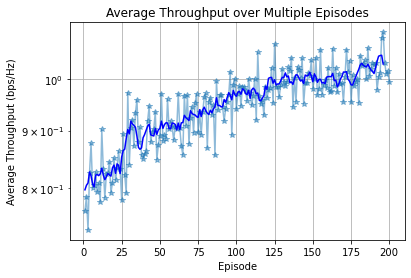

In [223]:
# import numpy as np
# import matplotlib.pyplot as plt

# Example data (replace this with your own data)
# episodes = np.arange(1, 101)  # episode numbers
# real_rewards = np.random.normal(0, 1, size=(100,))  # replace with your actual rewards

# Function to calculate a simple moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Set the window size for smoothing
window_size = 5

# Calculate the moving average of real rewards
smoothed_rewards = moving_average(avg_reward_all_episodes, window_size)

fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(all_epochs,avg_reward_all_episodes,'-*', alpha=0.5)
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Throughput (bps/Hz)')
ax1.set_title('Average Throughput over Multiple Episodes')
plt.grid(True)


# Plot the original real rewards with reduced opacity
# plt.plot(episodes, real_rewards, label='Real Rewards', color='blue', alpha=0.5)

# Plot the smoothed rewards
plt.plot(all_epochs[:-window_size+1], smoothed_rewards, label=f'Smoothed Rewards (Window Size={window_size})', color='blue')

# Add labels and legend
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title('Average Reward vs Episode with Smoothed Rewards')
# plt.legend()

# Show the plot
# plt.show()

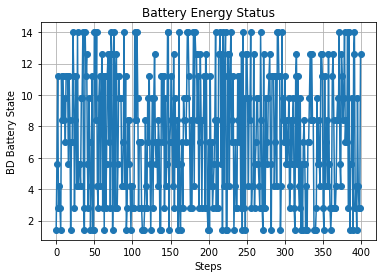

In [221]:
steps = np.arange(start = 0,stop=nSteps, step =1)
plt.plot(steps,E_B,'o-') 
plt.xlabel('Steps')
plt.ylabel('BD Battery State')
plt.title('Battery Energy Status')
plt.grid(True)
plt.show()

#plt.savefig('Bat_energy_status.png')

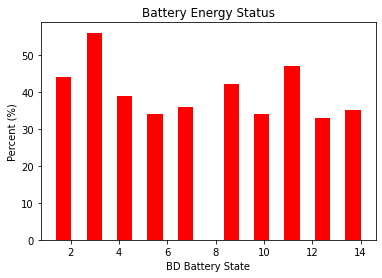

In [225]:
# import numpy as np
# import matplotlib.pyplot as plt

# Generate an array of random values (replace this with your actual data)
# data = np.random.randn(400)

# Plot the histogram
plt.hist(E_B, bins=20, color = 'red')

# Add labels and title
plt.xlabel('BD Battery State')
plt.ylabel('Percent (%)')
plt.title('Battery Energy Status')

# Show the plot
plt.show()


In [1]:
from  matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import numpy as np

# scores =[8190,666,278,145,113,83,52,48,45,44,45,29,28,45,29,15,16,10,17,7,15,6,10,7,3,5,7,4,2,3,0,1,0,0,0,0,0,0,0,29]
binbounds = np.round(np.linspace(0, 1, 41), 4)
rwidth = 0.7
width = binbounds[1] - binbounds[0]
bars = plt.bar(binbounds[:-1] + width / 2, height=E_B, width=width * rwidth, align='center')
plt.gca().xaxis.set_major_locator(MultipleLocator(0.1))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.05))
plt.yscale('log', nonposy='clip')
for rect in bars:
    x, y = rect.get_xy()
    w = rect.get_width()
    h = rect.get_height()
    plt.text(x + w / 2, h, f'{h}\n', ha='center', va='center')
plt.show()

NameError: name 'E_B' is not defined

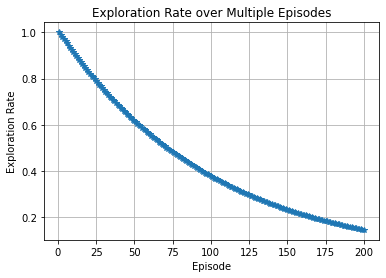

In [204]:
#Plotting exploration rate over multiple episodes

plt.plot(all_epochs,all_exploration_rate,'-*') 
plt.xlabel(r'Episode')
plt.ylabel(r'Exploration Rate')
plt.title('Exploration Rate over Multiple Episodes')
plt.grid(True)

#plt.savefig('exploration_rate.png')

### for debugging ###

In [29]:
f = 900e6
fJ = 900e6

# **** for path loss ****

# P_J = 20
# Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
# Gt_dBi = 1 #Gain of the Tx antenna in dBi 
# Gr_dBi = 1 #Gain of the Rx antenna in dBi
# d0 = 1 #reference distance of receiver from the transmitter in meters
# d = 10 # 
# dJ = 2 #distance between Tx and Rx
# L = 1 #Other System Losses, for no Loss case L=1
# sigma=2 #Standard deviation of log Normal distribution (in dB)
# n=2 #
# APBD_path_loss_dB = logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
# jammer_path_loss_dB = logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,fJ,d0,dJ,L,sigma,n)
# print('APBD Path Loss in dB: ',APBD_path_loss_dB)
# print('Jammer Path Loss in dB: ',jammer_path_loss_dB)

# **** for gain ****

H = APBD_ChannelGain(f)
JBD = JBD_ChannelGain(fJ)
JAP = JAP_ChannelGain(fJ)
print('AP - BD Channel Gain: ',H)
#print('AP - BD distance: ',d)
print('Jammer - AP Channel Gain: ',JAP)
print('Jammer - BD Channel Gain: ',JBD)
#print('Jammer - AP/BD Distance: ',dJ)

AP - BD Channel Gain:  3.9746682786871815e-06
Jammer - AP Channel Gain:  7.159172811053648e-05
Jammer - BD Channel Gain:  7.469381116174979e-05


In [57]:
## Mean Jamming Power Received at AP ##
def Mean_Jam_Power(P_J,f_J):
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    lambda_ = (3*10**8)/(f_J)
    d = 2 #distance between J and AP
    n=2 # path loss exponent
    PR_J = P_J*((Gt_dBi*Gr_dBi*(lambda_**2))/((d**n)*(4*np.pi)**2)) # in Watt
    return PR_J 

In [201]:
n = -1 
#Jammer Strategy: Static Jammer
(P_J,f_J,n) = Jammer(n)

k = 3 # AP channel 
f_k = Fc + (k*deltaf)

#f_J = 930e6
        #reflection coefficient: s_bb = -1 for mu = 0=> non-reflecting state, s_bb = 1 for mu = 1=>reflecting state
# unwanted_signal = Mean_Jam_Power(P_J,f_J) + loopback_Channel()*abs(x) + abs(complex_noise(0, 1, N*L))
# y_AP_squared = ((s_bb**2)*P_T*APBD_ChannelGain(f_k)*abs(x)) + ((s_bb**2)*P_J*APBD_ChannelGain(f_k)*abs(x)*JBD_ChannelGain(f_J)*abs(x_J)) + loopback_Channel()*abs(x) + abs(complex_noise(0, 1, N*L))
#         #print(y_AP_squared[step])

P_R = ((s_bb**2)*P_T*(APBD_ChannelGain(f_k))**2) 
P_R_AP = sum(P_R)/(N*L) #Average Received Power
Noise_variance = (P_R_AP)/(10**(20/10)) #Desired SNR assumed to be 20dB
unwanted_signal = 1*(f_k == f_J)*P_J*JAP_ChannelGain(f_J) + loopback_Channel() + Noise_variance*abs(complex_noise(0, 1, N*L))
### 1*(f_k == f_J)*... => 0 if f_K is not equal to f_J
P_N = sum(unwanted_signal)/(N*L)
SNR =  P_R_AP/P_N
# SNR_dB = 10*math.log(SNR)
# #print(SNR)
throughput = math.log2(1+SNR) #SNR in linear scale will give throughput in bps; Here, throughput (reward) is in bps/Hz
# print(unwanted_signal)
# print(y_AP_squared)
# print('AP Channel: ',f_k)
# print('Jammer Channel: ',f_J)
print('Received Power: ',P_R_AP)
print('Noise Power: ',P_N)
print('SNR: ',SNR)
print('SNR in dB: ',SNR_dB)
print('Throughput: ',throughput)
print('Jammer channel: ',f_J)
print('AP Channel: ',f_k)

Received Power:  7.244212922368149e-10
Noise Power:  1.1587543447289114e-09
SNR:  0.6251724496500525
SNR in dB:  -2.009890124667679
Throughput:  0.7005928129439196
Jammer channel:  900000000.0
AP Channel:  930000000.0


In [177]:
Noise_variance

7.717206197566203e-12